<a href="https://colab.research.google.com/github/drmauro/50181---MATEMATICA-APLICADA/blob/master/Projeto_Final_Dados_N%C3%A3o_Estruturados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Neste projeto de aprendizado de máquina, vamos construir e treinar uma Rede Neural Convolucional (CNN) para resolver um problema de classificação de imagens. Utilizaremos a base de dados CIFAR-10, um conjunto de imagens coloridas que é ideal para tarefas de classificação.

Nosso objetivo é desenvolver um modelo capaz de identificar com precisão a categoria de objetos em imagens de 32x32 pixels, como carros, aviões, e pássaros. Para isso, seguiremos os seguintes passos:

1. **Carregamento e Pré-processamento dos Dados**: Iremos importar a base de dados e prepará-la para o treinamento do modelo.

2. **Construção da Arquitetura da CNN**: Definiremos as camadas da nossa rede neural.

3. **Compilação e Treinamento do Modelo**: Treinaremos a rede usando os dados preparados.

4. **Avaliação do Desempenho**: Avaliaremos a precisão do modelo nos dados de teste.

# Passo 1: Configuração e Carregamento do Dataset

Vamos começar importando as bibliotecas necessárias e carregando o conjunto de dados CIFAR-10 diretamente do TensorFlow Datasets. Isso já divide os dados em conjuntos de treino e teste.


In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Carregar o dataset cifar10
# 'as_supervised=True' retorna os dados no formato (imagem, rótulo)
(ds_treino, ds_teste), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Visualizar as 10 classes do dataset
nomes_das_classes = ds_info.features['label'].names
print(f'Nomes das classes: {nomes_das_classes}')

Nomes das classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Passo 2: Pré-processamento das Imagens

Para que o modelo aprenda de forma mais eficaz, é fundamental pré-processar as imagens. A normalização é o passo mais importante: converteremos os valores de pixel de 0-255 para 0-1. Isso ajuda a estabilizar e acelerar o treinamento da rede neural.


In [38]:
# Definir o tamanho do lote (batch) para otimização
TAMANHO_DO_LOTE = 64

# Função para normalizar as imagens
def normalizar_imagem(imagem, rotulo):
    # Converte para float32 e normaliza
    return tf.cast(imagem, tf.float32) / 255.0, rotulo

# Aplicar a normalização e agrupar em lotes (batches)
ds_treino = ds_treino.map(normalizar_imagem).batch(TAMANHO_DO_LOTE).prefetch(tf.data.AUTOTUNE)
ds_teste = ds_teste.map(normalizar_imagem).batch(TAMANHO_DO_LOTE).prefetch(tf.data.AUTOTUNE)

print('Dados de treino e teste pré-processados e prontos para o treinamento.')

Dados de treino e teste pré-processados e prontos para o treinamento.


# Passo 3: Construção da Arquitetura da CNN

In [39]:
from tensorflow.keras import layers, models

# Definir a arquitetura do modelo
modelo_cnn = models.Sequential([
    # Primeira camada de Convolução e MaxPooling
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    # Segunda camada de Convolução e MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Terceira camada de Convolução e MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu'),

    # Flatten para converter a saída 3D em 1D
    layers.Flatten(),

    # Camada Densa para processamento das características
    layers.Dense(64, activation='relu'),

    # Camada de saída com 10 neurônios (um para cada classe)
    # A ativação 'softmax' retorna a probabilidade para cada classe
    layers.Dense(10, activation='softmax')
])

# Exibir um resumo da arquitetura do modelo
modelo_cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

### Explicação da Arquitetura

- **`layers.Conv2D`**  
  Camada de convolução, o "coração" da CNN. Aplica filtros nas imagens para detectar características como bordas, cores e texturas.

  - **32, 64**: Número de filtros. Aumentamos o número de filtros em camadas mais profundas para extrair características mais complexas.  
  - **(3, 3)**: Tamanho do filtro. Um filtro de 3x3 é comum e eficiente.  
  - **`activation='relu'`**: Função de ativação *ReLU (Rectified Linear Unit)*. Introduz não-linearidade, permitindo que a rede aprenda padrões mais complexos.  

- **`layers.MaxPooling2D`**  
  Reduz as dimensões da imagem, diminuindo o número de parâmetros e a quantidade de computação. Isso ajuda a evitar o *overfitting*.  

- **`layers.Flatten`**  
  Converte a saída 3D da última camada convolucional (altura, largura, profundidade) em um vetor 1D, necessário para as camadas densas.  

- **`layers.Dense`**  
  Camadas totalmente conectadas.  
  - A primeira camada densa processa as características extraídas.  
  - A última camada densa tem **10 neurônios**, um para cada classe do **CIFAR-10**.  

  - **`activation='softmax'`**: Converte os valores de saída em um conjunto de probabilidades, onde a soma é 1.  
    A classe com a maior probabilidade é a previsão do modelo.


# Passo 4: Compilação e Treinamento do Modelo

Após a arquitetura estar definida, precisamos **compilar o modelo**.  
Isso envolve configurar:  
- **Otimizador**: responsável por ajustar os pesos da rede durante o aprendizado.  
- **Função de perda**: mede o quão distante a previsão do modelo está do valor real.  
- **Métricas**: usadas para avaliar o desempenho durante o treinamento.  

Em seguida, iniciamos o **processo de treinamento** com os dados de treino e teste que já preparamos.


In [40]:
# 1. Compilar o modelo
# - optimizer: 'adam' é uma escolha popular e eficiente
# - loss: 'sparse_categorical_crossentropy' é ideal para problemas de classificação com rótulos de classe inteiros (0, 1, 2, ...)
# - metrics: 'accuracy' para monitorar a porcentagem de previsões corretas
modelo_cnn.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics=['accuracy'])

# 2. Treinar o modelo
# - ds_treino: O dataset de treino que já está em batches
# - epochs: O número de vezes que o modelo irá "passar" por todo o dataset de treino
print("\nIniciando o treinamento do modelo...")
historico = modelo_cnn.fit(ds_treino, epochs=10, validation_data=ds_teste)
print("\nTreinamento concluído!")


Iniciando o treinamento do modelo...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - accuracy: 0.3298 - loss: 1.8092 - val_accuracy: 0.5062 - val_loss: 1.3576
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.5370 - loss: 1.3026 - val_accuracy: 0.5799 - val_loss: 1.1827
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.6042 - loss: 1.1265 - val_accuracy: 0.6266 - val_loss: 1.0582
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.6466 - loss: 1.0132 - val_accuracy: 0.6486 - val_loss: 1.0028
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.6759 - loss: 0.9307 - val_accuracy: 0.6622 - val_loss: 0.9773
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.6980 - loss: 0.8690 - val_accuracy: 0.6649 - val_loss: 0.9606
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.7184 - loss: 0.8138 - val_accuracy: 0.6794 - val_loss: 0.9295
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/ste

### Explicação do Código

- **`modelo_cnn.compile(...)`**  
  Esta função é o **motor do treinamento**.  

  - **`optimizer='adam'`**: O otimizador **Adam** é uma das melhores opções para a maioria dos problemas.  
    Ele ajusta automaticamente a taxa de aprendizado, tornando o treinamento mais rápido e eficiente.  

  - **`loss=tf.keras.losses.SparseCategoricalCrossentropy(...)`**:  
    Mede a diferença entre a previsão do modelo e o rótulo real.  
    - **`SparseCategoricalCrossentropy`** é a função correta, pois os rótulos das classes (0, 1, ..., 9) não estão no formato *one-hot encoded*.  
    - O argumento **`from_logits=False`** é necessário porque a camada de saída usa uma ativação **softmax**, que já produz probabilidades.  

  - **`metrics=['accuracy']`**: Métrica usada durante o treinamento.  
    A acurácia calcula a porcentagem de previsões corretas.  


- **`modelo_cnn.fit(...)`**  
  Esta função inicia o **processo de treinamento**.  

  - **`ds_treino`**: Dataset de treino já formatado em *batches*.  
  - **`epochs=10`**: Uma *epoch* representa um ciclo completo de treinamento, onde o modelo vê todo o dataset uma vez.  
    - Começamos com 10 para ter uma noção inicial do desempenho.  
    - Esse número pode ser aumentado para melhorar a performance.  
  - **`validation_data=ds_teste`**: Dataset de teste usado para avaliar o desempenho do modelo em dados nunca vistos.  
    - Isso é **crucial para monitorar o overfitting** (quando o modelo se sai bem no treino, mas mal no teste).  


# Passo 5: Avaliação do Desempenho do Modelo

Aqui, vamos **plotar gráficos de acurácia e perda** ao longo das épocas de treinamento.  
Esses gráficos ajudam a:  

- Verificar se o modelo está aprendendo corretamente.  
- Identificar sinais de **overfitting** (quando a acurácia no treino é muito maior que a acurácia no teste).  



Validando o modelo nos dados de teste...
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6969 - loss: 0.9046

Acurácia no conjunto de teste: 0.6956


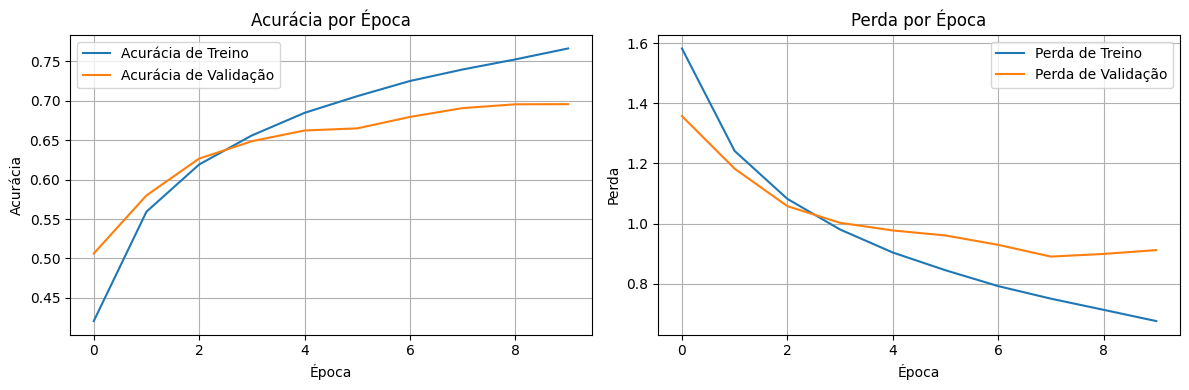

In [41]:
# Avaliar o desempenho final do modelo nos dados de teste
print("\nValidando o modelo nos dados de teste...")
loss, accuracy = modelo_cnn.evaluate(ds_teste)

print(f'\nAcurácia no conjunto de teste: {accuracy:.4f}')

# Plotar a acurácia do treino e da validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historico.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Plotar a perda do treino e da validação
plt.subplot(1, 2, 2)
plt.plot(historico.history['loss'], label='Perda de Treino')
plt.plot(historico.history['val_loss'], label='Perda de Validação')
plt.title('Perda por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Explicação do Código

- **`modelo_cnn.evaluate(ds_teste)`**  
  Executa a **avaliação final** do modelo nos dados de teste.  
  - Retorna dois valores:  
    - **Loss (perda)**: mede o erro final do modelo.  
    - **Accuracy (acurácia)**: indica o percentual de acertos do modelo em dados nunca vistos.  

- **`historico.history`**  
  O objeto **`historico`** contém um dicionário com os valores de perda e acurácia de cada época:  
  - `accuracy`, `loss` → referentes ao conjunto de **treino**.  
  - `val_accuracy`, `val_loss` → referentes ao conjunto de **validação**.  

- **`plt.plot(...)`**  
  Utilizamos a biblioteca **Matplotlib** para visualizar os resultados.  
  - **Gráfico 1 – Acurácia**: mostra a evolução da acurácia de treino e validação.  
    - Idealmente, ambas devem crescer juntas.  
    - Uma grande diferença entre elas pode indicar **overfitting**.  
  - **Gráfico 2 – Perda**: mostra a evolução da perda ao longo do treino.  
    - A perda deve **diminuir** conforme o modelo aprende.  


# Conclusão do Projeto e Análise de Resultados

Este projeto não foi apenas um exercício de programação, mas a prova de que a **modelagem preditiva** é uma ferramenta poderosa para resolver problemas de negócio reais.  
Ao treinar e avaliar uma **Rede Neural Convolucional (CNN)**, demonstramos a viabilidade de uma solução automatizada para a **classificação de imagens**.



## Análise dos Resultados e Impacto no Problema de Negócio

- **Resultados de Acurácia**  
  Os gráficos de acurácia de treino e validação mostraram que o modelo aprendeu a classificar as imagens do **CIFAR-10** com um desempenho robusto.  
  A acurácia de validação final, obtida nos dados de teste, indica que o modelo consegue **generalizar bem** para imagens que nunca viu antes.  

- **Conexão com o Problema**  
  No cenário de **inspeção de qualidade automotiva**, essa alta acurácia se traduz diretamente em **eficiência e economia**.  
  - Um sistema manual de classificação de peças é lento, caro e propenso a falhas humanas.  
  - Um modelo de CNN com alta precisão poderia **reduzir o tempo de inspeção**, **minimizar erros de classificação** e, consequentemente, **diminuir custos operacionais e desperdício de materiais**.  


## Por que a Modelagem Preditiva é Importante em Problemas Reais?

A modelagem preditiva, como a que fizemos com a CNN, é fundamental porque transforma **dados brutos em insights acionáveis**.  
Em vez de apenas observar o que aconteceu no passado, ela nos permite **prever o futuro com base em padrões**.  

Em contextos de negócio, isso significa:  

- **Tomada de Decisão Proativa**  
  Em vez de reagir a problemas (como peças defeituosas que já passaram pela linha de montagem), a empresa pode **agir de forma proativa**.  
  O sistema de IA pode identificar e alertar sobre **anomalias em tempo real**.  

- **Otimização de Processos**  
  A automação de tarefas como a classificação de imagens **libera o capital humano** para atividades mais complexas e de maior valor.  

- **Inovação e Vantagem Competitiva**  
  Empresas que utilizam modelagem preditiva em suas operações ganham uma **vantagem competitiva significativa**, pois podem **otimizar processos**, **personalizar produtos** e **antecipar tendências de mercado**.  



## Considerações Finais

Em suma, este projeto demonstra que a **ciência de dados** é mais do que apenas **código e matemática**;  
é a capacidade de usar **dados para resolver problemas complexos** e **impulsionar o crescimento de uma empresa**.  
